                                                                       TEMUULEN Bulgan - 2022427

### CCT College Dublin Continuous Assessment No.2
# AN ANALYSIS OF INDIAN FARMERS' PROTEST TWEETS.

#### Brief Introduction of the project:

1. For my second continuous assessment, I choose CSV format data of Indian Farmer's Protest Tweets. This file contains over 1 million English language tweets tweeted between November 1st, 2020 and november 21st, 2021 with the hashtag <#FarmersProtest>. It is downloaded from the Kaggle website with the CCO:Public Domain license.
(https://kaggle.com/datasets/prathamsharma123/farmers-protest-tweets-dataset-csv)

2. I divided my project into 3 primary sections (Every step in data processing and analysis is fully discussed on each subsection of these primary sections.):
    1. data cleaning and data storage
    2. data preprocessing 
    3. data visaluasation and forecast
    4. sentimental analysis model in Pyspark
    5. databases and comparison

3. I used Git for daily code tracking and GitHub for archiving, monitoring and sharing. To view the whole project on GitHub, click on the follwig link 

#### Libraries and modules used for this project:

In [1]:
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
import nltk
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark

## 1. Data cleaning and data storage.

For my second continous project I choose Kaggle.com's dataset called 'Farmers Protest Tweets'. It was collected by the hashtag #FarmersProtest including CCO:Pulic Domain license which means that this dataset allows copy, modify, distribute and perform the work, even for commercial purpososes, all without asking permission. All the tweets in it in English Language and collected from Twitter.com from November 1st, 2020 to November 21st, 2021. The main subject matter of these tweets are about the biggest anti-farm laws protest which took place at the borders of the Indian natioanl capital of New Delhi, organized by coalition of over 40 farmer from across the country.The dataset extraction process was done by Pratham Sharma, kaggle datasets expert who used Twitter API and  snscrape Python library for collection. The tweets data consist of two separate CSVL files with the size of 1.7 GB and 81.2 MB.

In [3]:
# Checking the file size of the file.
file_size = os.path.getsize('/home/hduser/Desktop/ca/tweets.csv')/(1024*1024*1024)
print(f'The size of the tweets file is: {file_size:.2f} GB.')
file_size = os.path.getsize('/home/hduser/Desktop/ca/users.csv')/(1024*1024)
print(f'The size of the users file is: {file_size:.2f} MB.')

The size of the tweets file is: 1.69 GB.
The size of the users file is: 81.18 MB.


### 1.1. *Data storing and its preparation.*

Before to start processing the DataSet in distributed file system platforms I decided to examine each CSV file using Pandas on Jupyter Notebook.

#### *tweets.csv*

In [4]:
# Creating a DataFrame.
df_tweets = pd.read_csv('/home/hduser/Desktop/ca/tweets.csv')

# Checking the DataFrame.
df_tweets.head(2)

,tweetUrl,date,renderedContent,tweetId,userId,replyCount,retweetCount,likeCount,quoteCount,source,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/ShashiRajbhar6/status/1376...,2021-03-30 03:33:46+00:00,Support 👇\n\n#FarmersProtest,1.376739e+18,1.015970e+18,0,0,0,0,"<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN
1,https://twitter.com/kaursuk06272818/status/137...,2021-03-30 03:33:23+00:00,Supporting farmers means supporting our countr...,1.376739e+18,1.332937e+18,0,0,0,0,"<a href=""http://twitter.com/download/android"" ...",[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,NaN,NaN


In [5]:
# Printing information about the DataFrame
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084452 entries, 0 to 1084451
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   tweetUrl         1084452 non-null  object 
 1   date             1084452 non-null  object 
 2   renderedContent  1084452 non-null  object 
 3   tweetId          1084452 non-null  float64
 4   userId           1084452 non-null  float64
 5   replyCount       1084452 non-null  int64  
 6   retweetCount     1084452 non-null  int64  
 7   likeCount        1084452 non-null  int64  
 8   quoteCount       1084452 non-null  int64  
 9   source           1072318 non-null  object 
 10  media            319141 non-null   object 
 11  retweetedTweet   0 non-null        float64
 12  quotedTweet      286988 non-null   object 
 13  mentionedUsers   412206 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 115.8+ MB


#### *users.csv*

In [6]:
# Creating a DataFrame.
df_users = pd.read_csv('/home/hduser/Desktop/ca/users.csv')

# Checking the DataFrame.
df_users.head(2)

,username,displayname,userId,rawDescription,descriptionUrls,verified,created,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount,location,protected,linkUrl,profileImageUrl,profileBannerUrl,profileUrl
0,ShashiRajbhar6,Shashi Rajbhar,1.020000e+18,Satya presan 🤔ho Sakta but prajit💪 nhi\njhuth ...,[],False,2018-07-08T14:44:03+00:00,1788,1576,14396,26071,1,254,"Azm Uttar Pradesh, India",False,NaN,https://pbs.twimg.com/profile_images/135433129...,https://pbs.twimg.com/profile_banners/10159697...,https://twitter.com/ShashiRajbhar6
1,kaursuk06272818,KAUR SUKH🌾ਕੌਰ ਸੁਖ,1.330000e+18,ਜਿਓਣਾ ਕੀ ਸਰੀਰਾਂ ਦਾ ਜੇਕਰ ਹੋਣ ਜ਼ਮੀਰਾਂ ਮਰੀਆਂ 🌼,[],False,2020-11-29T06:40:06+00:00,51,68,1338,3676,0,607,NaN,False,NaN,https://pbs.twimg.com/profile_images/133295149...,https://pbs.twimg.com/profile_banners/13329372...,https://twitter.com/kaursuk06272818


In [7]:
# Printing information about the DataFrame
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235660 entries, 0 to 235659
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   username          235660 non-null  object 
 1   displayname       235625 non-null  object 
 2   userId            235660 non-null  float64
 3   rawDescription    190546 non-null  object 
 4   descriptionUrls   162616 non-null  object 
 5   verified          235660 non-null  bool   
 6   created           235660 non-null  object 
 7   followersCount    235660 non-null  int64  
 8   friendsCount      235660 non-null  int64  
 9   statusesCount     235660 non-null  int64  
 10  favouritesCount   235660 non-null  int64  
 11  listedCount       235660 non-null  int64  
 12  mediaCount        235660 non-null  int64  
 13  location          152110 non-null  object 
 14  protected         235660 non-null  bool   
 15  linkUrl           49700 non-null   object 
 16  profileImageUrl   23

As we can see from abowe first two code sells the DataSet with tweets consisted of 13 distinct columns of information where some of which is not very importand for further processing. The columns such as 'tweetUrl', 'tweetId', 'source', 'media', 'retweetedTweet', 'quotedTweet', 'mentionedUsers', and 'userId' doesn't include importand information for analysis.

On the other hand last two code sells show that the DataSet with users information consisted of 18 distincst columns of information from which I can only use only column with 'display name. So further I'm going to remove unnessecary columns from each DataFrame and merge them as one.

In [8]:
# Deleting columns from the DataFrame of tweets.
df_tweets = df_tweets.drop(labels=['tweetUrl', 'tweetId', 'source', 'media', 'retweetedTweet', 'quotedTweet', \
                                   'mentionedUsers'], axis=1)

# Checking the changes.
df_tweets.head(2)

,date,renderedContent,userId,replyCount,retweetCount,likeCount,quoteCount
0,2021-03-30 03:33:46+00:00,Support 👇\n\n#FarmersProtest,1.015970e+18,0,0,0,0
1,2021-03-30 03:33:23+00:00,Supporting farmers means supporting our countr...,1.332937e+18,0,0,0,0


In [9]:
# Deleting columns from the DataFrame of tweets.
df_users = df_users[['displayname', 'userId']]

# Checking the changes.
df_users.head(2)

,displayname,userId
0,Shashi Rajbhar,1.020000e+18
1,KAUR SUKH🌾ਕੌਰ ਸੁਖ,1.330000e+18


In [10]:
# Performing left merging on two DataFrames.
df_final = pd.merge(df_tweets, df_users, on='userId', how='left')

# Deleting the column 'userId'.
df_final = df_final.drop(labels=['userId'], axis=1)

# Checking the changes.
df_final.head(10)

,date,renderedContent,replyCount,retweetCount,likeCount,quoteCount,displayname
0,2021-03-30 03:33:46+00:00,Support 👇\n\n#FarmersProtest,0,0,0,0,NaN
1,2021-03-30 03:33:23+00:00,Supporting farmers means supporting our countr...,0,0,0,0,NaN
2,2021-03-30 03:31:00+00:00,Support farmers if you are related to food #St...,0,0,0,0,NaN
3,2021-03-30 03:30:45+00:00,#StopHateAgainstFarmers support #FarmersProtes...,0,1,3,0,Sukhdev Singh
4,2021-03-30 03:30:30+00:00,"You hate farmers I hate you, \nif you love the...",0,0,1,0,NaN
5,2021-03-30 03:29:56+00:00,They can't be farmers. Looks like Gundas are h...,0,0,0,0,Abhimanyu 🌏 🇮🇳
6,2021-03-30 03:29:56+00:00,They can't be farmers. Looks like Gundas are h...,0,0,0,0,Abhimanyu 🌏 🇮🇳
7,2021-03-30 03:28:50+00:00,Lets not forget that our Farmers are STILL out...,0,2,3,0,Japneet Singh
8,2021-03-30 03:28:49+00:00,@Troll48611422 @Doabapunjab1 @Terminator00096 ...,1,0,0,0,NaN
9,2021-03-30 03:28:09+00:00,"Neutrality helps the oppressor, never the vict...",0,0,0,0,Kisan Bot🚜🌾


I merged two DataFrames and removed unessary columns. Now I'm going to save the it as a CSV file on my Ubuntu VM. 

In [11]:
# Saving the DataFrame as 'new_tweets.csv' on my VM with the utf-8 Encoding.
df_final.to_csv('/home/hduser/Desktop/ca/new_tweets.csv', encoding='utf-8', index=False)

In [12]:
# Checking the file size.
new_file_size = os.path.getsize('/home/hduser/Desktop/ca/new_tweets.csv')/(1024*1024)
print(f'The size of new tweet file is: {new_file_size:.2f} MB.')

The size of new tweet file is: 670.19 MB.


The file size is reduced from 1.7GB to 670.2MB and it still have importand information of the tweets for further processing. I desided to store my new created twitter CSV dataset on HDFS from where I will use PySpark tools to perform data processing in a distributed environment.

### 1.2 *Data cleaning and manipulation.*

In this section I'll use PySpark, Python API for Apache Spark, to do the preprocessing step for Sentiment Analysis.

In [13]:
# Starting a new SparkSession for data import from HDFS.
spark = SparkSession.builder \
        .appName('Sentiment Analysis') \
        .getOrCreate()

In [14]:
# Reading the file.
df_spark = spark.read.option('header', 'true') \
                        .option('multiline', 'true') \
                        .option('quote', "\"") \
                        .option('escape', "\"") \
                        .csv('/ca2/new_tweets.csv')

Using 'SparkSession.builder' I created a new SparkSession for interacting with Spark functionality. Then I created a new PySpark DataFrame by importing the 'new_tweets.csv' file which is stored in HDFS's 'ca2' directory. 

#### *columns*

First thing I would like to do is check all the columns and its datatype. 

In [15]:
# Checking the contents of the DataFrame.
df_spark.show(10)

+--------------------+--------------------+----------+------------+---------+----------+-----------------+
|                date|     renderedContent|replyCount|retweetCount|likeCount|quoteCount|      displayname|
+--------------------+--------------------+----------+------------+---------+----------+-----------------+
|2021-03-30 03:33:...|Support 👇\n\n#Fa...|         0|           0|        0|         0|             null|
|2021-03-30 03:33:...|Supporting farmer...|         0|           0|        0|         0|             null|
|2021-03-30 03:31:...|Support farmers i...|         0|           0|        0|         0|             null|
|2021-03-30 03:30:...|#StopHateAgainstF...|         0|           1|        3|         0|    Sukhdev Singh|
|2021-03-30 03:30:...|You hate farmers ...|         0|           0|        1|         0|             null|
|2021-03-30 03:29:...|They can't be far...|         0|           0|        0|         0|Abhimanyu 🌏 🇮🇳|
|2021-03-30 03:29:...|They can't be far..

In [16]:
# Checking the columns of the DataFrame
x = 0
columns = ''
while x < len(df_spark.columns):
    columns += df_spark.columns[x] + ', '
    x += 1
print('Columns of the DataFrame are:', columns)

Columns of the DataFrame are: date, renderedContent, replyCount, retweetCount, likeCount, quoteCount, displayname, 


In [17]:
# Checking column dtypes.
df_spark.printSchema()

root
 |-- date: string (nullable = true)
 |-- renderedContent: string (nullable = true)
 |-- replyCount: string (nullable = true)
 |-- retweetCount: string (nullable = true)
 |-- likeCount: string (nullable = true)
 |-- quoteCount: string (nullable = true)
 |-- displayname: string (nullable = true)



I examined the DataFrame with its columns and found that because it was imported from the CSV file all 7 columns contained the string dtype values. I'll change the names of the columns to make it easy to use, and dtypes of the column values.

In [18]:
# Renaming the columns.
df_spark = df_spark.select(col('date').alias('date'),
                           col('displayname').alias('user'),
                           col('renderedContent').alias('tweet'),
                           col('replyCount').alias('replied'),
                           col('retweetCount').alias('retweeted'),
                           col('likeCount').alias('liked'),
                           col('quoteCount').alias('quoted'))

In [19]:
# Changing dtypes.
#df_spark = df_spark.withColumn('date',to_timestamp(col('date').cast(TimestampType())))
df_spark = df_spark.withColumn('tweet',col('tweet').cast(StringType()))
df_spark = df_spark.withColumn('user',col('user').cast(StringType()))
df_spark = df_spark.withColumn('replied',col('replied').cast('integer'))
df_spark = df_spark.withColumn('retweeted',col('retweeted').cast('integer'))
df_spark = df_spark.withColumn('liked',col('liked').cast('integer'))
df_spark = df_spark.withColumn('quoted',col('quoted').cast('integer'))

In [20]:
# Checking changes.
df_spark.show(2)

+--------------------+----+--------------------+-------+---------+-----+------+
|                date|user|               tweet|replied|retweeted|liked|quoted|
+--------------------+----+--------------------+-------+---------+-----+------+
|2021-03-30 03:33:...|null|Support 👇\n\n#Fa...|      0|        0|    0|     0|
|2021-03-30 03:33:...|null|Supporting farmer...|      0|        0|    0|     0|
+--------------------+----+--------------------+-------+---------+-----+------+
only showing top 2 rows



In [21]:
# Checking changes.
df_spark.printSchema()

root
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- replied: integer (nullable = true)
 |-- retweeted: integer (nullable = true)
 |-- liked: integer (nullable = true)
 |-- quoted: integer (nullable = true)



Now all the column values has the appropirate data format as well as the names of the columns are short and clear.

#### *null values and duplicates*

Second thing I would like to do for cleaning is removing the duplicates and null values.

In [22]:
# Examining the shape of the DataFrame
print('The DataFrame consists of', len(df_spark.columns), 'columns and', df_spark.count(), 'rows.')

The DataFrame consists of 7 columns and 2953850 rows.


The Dataframe consists of 2.953.850 rows and 7 colums. And as can be seen from the 'show()' method above it is obvious that there are lots of duplicates on it, so I would like to remove them. 

Moreover, there are some NaN values in the new merged column 'displayname'. It seems like some users that tweeted on the twitter doesn't have a Display Name. It might indicate that they no longer user of the social media plaform, or even might have blocked becuse of trolling or whatever reason, the account might have been deleted. So to prevent the bias and also to not waste my memory for extra processing I have decided to drop the rows which doesn't contain the display name or contain duplicate tweet entries.

After these changes I'll order table contents by the date.

In [23]:
# Dropping the duplicates and rows with null values then ordering the rows.
df_spark = df_spark.drop_duplicates()
df_spark = df_spark.filter(col('displayname').isNotNull())
df_spark = df_spark.orderBy('date')

In [24]:
# Checking the changes.
df_spark.show(10)

+--------------------+--------------------+--------------------+-------+---------+-----+------+
|                date|                user|               tweet|replied|retweeted|liked|quoted|
+--------------------+--------------------+--------------------+-------+---------+-----+------+
|2020-11-01 03:36:...|Manickam Tagore ....|Yesterday in a pu...|      8|       95|  389|     5|
|2020-11-01 10:54:...|        ClaireDeLune|Has this been rep...|      0|        0|    1|     0|
|2020-11-01 12:10:...|          Rajay Deep|Such a shame!\n\n...|      0|        0|    2|     0|
|2020-11-01 23:55:...|          OnTheFritz|@WhiteHouse @real...|      1|        0|    3|     0|
|2020-11-02 02:28:...|Fateh Singh  Bhullar|Other side of APM...|      0|        0|    1|     0|
|2020-11-02 06:59:...|IndoAsianCommodities|Given #FarmersPro...|      0|        0|    0|     0|
|2020-11-02 14:42:...|     pravingandhino1|.@asadowaisi \nTh...|      0|        0|    0|     0|
|2020-11-02 15:06:...|   Vishal Maheshwa

In [25]:
# Checking the changes.
print('The DataFrame consists of', len(df_spark.columns), 'columns and', df_spark.count(), 'rows.')

The DataFrame consists of 7 columns and 1082432 rows.


In [26]:
# Checking null values on entire DataFrame.
df_spark.filter(col('date').isNull() | col('user').isNull() | col('tweet').isNull() | col('replied').isNull() | \
                col('retweeted').isNull() | col('liked').isNull() | col('quoted').isNull()).show()

+----+----+-----+-------+---------+-----+------+
|date|user|tweet|replied|retweeted|liked|quoted|
+----+----+-----+-------+---------+-----+------+
+----+----+-----+-------+---------+-----+------+



Above executed cells show that now the DataFrame shape is 1.066.380x7. There are no dublicates and no null values, it is now clean and clear. However since I'll do the sentimental analysis for this project I would like to clean the entries of the column 'tweet'.

#### *the column 'tweet'*

Firstly I will remove tags, hashtags, emails, links from the tweets because I would like to focus on the text itself, rather than considering the additional context. They extra contexts are not  directly contribute to the sentiment of the tweet.

In [27]:
# Removing tags, hashtags, emails, and website links from the values of the column 'tweet'.
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', r'@\w+|#\S+|\S+@\S+|http\S+|www\S+|\S+/\S+', ''))

In [28]:
# Checking changes.
df_spark.select('tweet').orderBy('tweet', ascending=False).limit(10).show(10, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|🧵appalled by the academics RT’ing India’s covid surge while still clueless about  India blocked protestors out of their own capitol &amp; will now argue that protestors are creating barriers to emergen

Emails, links, tags, hashtags from The 'tweet' column values were successfully removed, however, from the above cell I can see that the  column 'tweet' still missing some cleaning. Further, I will remove leading and traling whitespaces, '&amp' character referencing for an ampersand, punctuation marks and non-English texts from the string value of the column. Then, I'll replace two or more continous whitespaces with a single whitespace, and also, I'll replace the new line and tab with ' '. And lastly I'll lowercase the entire string for each column value.

In [30]:
# Extra cleaning for the 'tweet' column values
df_spark = df_spark.withColumn('tweet', trim(df_spark.tweet))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', r'\b\w{0,1}\b', ''))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', '&amp', ' '))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', '[\|,.;:\?!_+-]', ' '))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', r'\s{2,}', ' '))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', r'\n|\t', ' '))
df_spark = df_spark.withColumn('tweet', regexp_replace('tweet', "[^a-zA-Z0-9!@#$%^&*()_+\-={}\[\]|\\;:'\",.<>/?~` ]", ''))
df_spark = df_spark.withColumn('tweet', lower(df_spark.tweet))

In [31]:
# Checking changes.
df_spark.select('tweet').show(10, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|yesterday in public meeting alleged that leader staged managed protest of farmer by burning his own crop field today vaartha front page news covered in chandrasekar garu home district now what you will say|
|has this been reported on msm or are they ignoring this                                                                                                                

Ok, the cleaning is done and it looks fine. I'll safe this DataFrame to HDFS as CSV file. 

In [32]:
# Saving the DataFrame to HDFS.
df_spark.write.format('csv').save('hdfs://localhost:9000/ca2/tweets')

## 2. Data preprocessing.

Since I'm using tweet DataSet about the protest it is obvious that the most tweets would have negative tone of writing. And instead of focusing solely on positive or negative sentiments I decided to use lexicon-based emotion analysis approach for my Sentiment Analysis which is more nuanced analysis approach at the sense level. I choose NRC-Emotion-Lexicon-Senselevel-v0.92 which associates emotions with specific word senses of or meaning. It includes emotions such as anger, anticipation, disgust, fear, joy, sadness, surprice and trust.

Moreover, I tried to apply lemmatization and spellcheking tools for the whole dataset in Pandas DataFrame, but beacuse of my VM potiantial I wasn't able to finish the process. I waited for 4 hours to execute line of code for spell checking for the whole dataframe and it didn't finish the execution. So I decided to choose one of the users and work specifically on that users tweet. The twitter user I choose for the tweets is IndiaToday, a twitter page of a weekly news magazine. This page has in total 3480 tweets regarding to the protest from 21.11.2020 using the hashtag #FarmersProtest. In my opinion if we follow this page tweet we can not only analyze the sentiment of the tweet and also can understand circumstances of the event.

In [33]:
# The count of the most tweets from the users.
df_spark.groupBy('user').count().sort('count', ascending=False).show()

+--------------------+-----+
|                user|count|
+--------------------+-----+
|  The Pacifist Rebel| 7766|
|       Kisan Bot🚜🌾| 7338|
| ਸਰਦਾਰ ਸਾਬ(A Farmer)| 5020|
|ਕਿਸਾਨAndolajivi R...| 4107|
|ਕਿਸਾਨAndolajivi r...| 4107|
|             Navneet| 3707|
|       Navneet Jammu| 3659|
|          IndiaToday| 3480|
|           🍊raman🚜| 3338|
|                 Jot| 3235|
|PARSHOTAM SINGH S...| 3210|
|Jaz 🇨🇦🌾 ਗਰਮ ਖਿਆਲੀ| 3052|
|     Manminder Singh| 2563|
|For love of Punja...| 2547|
|Jaspal Kaur Bains...| 2547|
|    Kuldeep Dhaliwal| 2547|
|                John| 2489|
|ਤਕਦੀਰ ਕੌਰ 🇺🇸 ਦੁਆਬਣ| 2480|
|    Er. V P Vashisht| 2438|
|    Shivinder Thakur| 2428|
+--------------------+-----+
only showing top 20 rows



In [34]:
# Creating a DataFrame.
df_for_sentiment = df_spark.filter(col('user').like('%IndiaToday%'))

In [35]:
# Checking the results.
df_for_sentiment.show(3)

+--------------------+----------+--------------------+-------+---------+-----+------+
|                date|      user|               tweet|replied|retweeted|liked|quoted|
+--------------------+----------+--------------------+-------+---------+-----+------+
|2020-11-21 11:04:...|IndiaToday|farmers allow tra...|      0|        1|   17|     0|
|2020-11-25 09:38:...|IndiaToday|police resorted t...|      0|        2|   13|     0|
|2020-11-26 04:14:...|IndiaToday|heavy police depl...|      0|        2|    8|     0|
+--------------------+----------+--------------------+-------+---------+-----+------+
only showing top 3 rows



In [36]:
# Examining the shape of the DataFrame.
print('The DataFrame consists of', len(df_for_sentiment.columns), 'columns and', df_for_sentiment.count(), 'rows.')

The DataFrame consists of 7 columns and 3480 rows.


### 2.2 *Tokenization*

Next step is tokenizing, using the default 'Tokenizer' class from the 'pyspark.ml.feature' module, it  will split text into individual tokens based on default delimiter in this case is 'whitespace'. 

In [37]:
# Splitting tweet strings into tokenized text.
tokenizer = Tokenizer(inputCol='tweet', outputCol='token')
df_for_sentiment = tokenizer.transform(df_for_sentiment)

In [38]:
# Checking the changes.
df_for_sentiment.show(3)

+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+
|                date|      user|               tweet|replied|retweeted|liked|quoted|               token|
+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+
|2020-11-21 11:04:...|IndiaToday|farmers allow tra...|      0|        1|   17|     0|[farmers, allow, ...|
|2020-11-25 09:38:...|IndiaToday|police resorted t...|      0|        2|   13|     0|[police, resorted...|
|2020-11-26 04:14:...|IndiaToday|heavy police depl...|      0|        2|    8|     0|[heavy, police, d...|
+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+
only showing top 3 rows



### *2.3 Stop word removal*


I have now a new column 'token' with tokenized text on it, and when I look closer to the text in it there are lots of stop words that are not very inportant for further processing. Since they do not carry sifnificant meaning or contribute to the sentiment of a text, by removing them I will reduce noise and focus on the more meaningful words.

In [39]:
# Removing stop words from token text.
stopwords = StopWordsRemover.loadDefaultStopWords('english')
remover = StopWordsRemover(inputCol='token', outputCol='clean_token', stopWords=stopwords)
df_for_sentiment = remover.transform(df_for_sentiment)

In [40]:
# Checking the changes.
df_for_sentiment.select('clean_token').show(3, False)

+------------------------------------------------------------------------------------------------------+
|clean_token                                                                                           |
+------------------------------------------------------------------------------------------------------+
|[farmers, allow, trains, resume, warning, )]                                                          |
|[police, resorted, use, water, cannons, disperse, farmers, gathered, near, chandigarh, delhi, highway]|
|[heavy, police, deployment, delhi, border, farmers, call, bandh]                                      |
+------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [41]:
# Checking stop words list for PySpark.ML.
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

### *2.4 Spellcheck and lemmatization on Pandas*

As it can bee seen from above subsection I have removed default stop words from the token text and now I would like to do the spell check and lemmatizzation, which will examine each word to fix grammer errors and reduce words to their base or root form. It will help me normalize words and reduce the dimentionality of each row, which will lead to  for more accurate polarity of the sentiment.

I tried lots of different libraries which has spell check and lemmatization tools in it however all of them didn't work with PySpark. There were some Javascript errors on execution process, some  had library import error, some libraries stopped development of the tool for PySpark and etc. So that I decided to convert my PySpark DataFrame to Pandas DataFrame and use 'autocorrect' for spell correcting and 'nltk' for lemmatization.

In [42]:
# Checking the DataFrame
df_for_sentiment.show(3)

+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+--------------------+
|                date|      user|               tweet|replied|retweeted|liked|quoted|               token|         clean_token|
+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+--------------------+
|2020-11-21 11:04:...|IndiaToday|farmers allow tra...|      0|        1|   17|     0|[farmers, allow, ...|[farmers, allow, ...|
|2020-11-25 09:38:...|IndiaToday|police resorted t...|      0|        2|   13|     0|[police, resorted...|[police, resorted...|
|2020-11-26 04:14:...|IndiaToday|heavy police depl...|      0|        2|    8|     0|[heavy, police, d...|[heavy, police, d...|
+--------------------+----------+--------------------+-------+---------+-----+------+--------------------+--------------------+
only showing top 3 rows



In [43]:
# Creating new DataFrame for Pandas
df_for_pandas = df_for_sentiment.select('date', 'tweet', 'clean_token', 'replied', 'retweeted', 'liked', 'quoted')

# Converting the values of the 'date' column to strings.
#df_for_pandas = df_preprocessing.withColumn('date', col('date').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('tweet', col('tweet').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('clean_token', col('clean_token').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('replied', col('replied').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('retweeted', col('retweeted').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('liked', col('liked').cast('string'))
df_for_pandas = df_for_sentiment.withColumn('quoted', col('quoted').cast('string'))

# Using all column Pandas but not including the column'token'.
df_for_pandas = df_for_pandas.select('date', 'tweet', 'clean_token', 'replied', 'retweeted', 'liked', 'quoted')

# Conversion from Pyspark to Pandas
df_pandas = df_for_pandas.toPandas()

In [44]:
# Checking the changes
df_pandas.head(3)

,date,tweet,clean_token,replied,retweeted,liked,quoted
0,2020-11-21 11:04:03+00:00,farmers allow trains to resume with warning ),"[farmers, allow, trains, resume, warning, )]",0,1,17,0
1,2020-11-25 09:38:38+00:00,police resorted to use of water cannons to dis...,"[police, resorted, use, water, cannons, disper...",0,2,13,0
2,2020-11-26 04:14:59+00:00,heavy police deployment at delhi border as far...,"[heavy, police, deployment, delhi, border, far...",0,2,8,0


As I mentioned earlier I'm trying to keep the column with dates together with the column of tweets because if i process tweets separatily I will loose the order that I'm trying to keep for further processing. And also in this case I'm keeping tweet column to compare the changes with the outcome.

#### *spellcheck*

In [45]:
# Initializing the spell checker.
spell = Speller()

In [46]:
# Defining a function to perform spell checking on a single token.
def spell_check_token(token):
    return spell(str(token))

# Executing correction.
df_pandas['corrected_token'] = df_pandas['clean_token'].apply(spell_check_token)

In [47]:
# Checking the changes
df_pandas.head(3)

,date,tweet,clean_token,replied,retweeted,liked,quoted,corrected_token
0,2020-11-21 11:04:03+00:00,farmers allow trains to resume with warning ),"[farmers, allow, trains, resume, warning, )]",0,1,17,0,"['farmers', 'allow', 'trains', 'resume', 'warn..."
1,2020-11-25 09:38:38+00:00,police resorted to use of water cannons to dis...,"[police, resorted, use, water, cannons, disper...",0,2,13,0,"['police', 'resorted', 'use', 'water', 'cannon..."
2,2020-11-26 04:14:59+00:00,heavy police deployment at delhi border as far...,"[heavy, police, deployment, delhi, border, far...",0,2,8,0,"['heavy', 'police', 'deployment', 'delhi', 'bo..."


A had standardized the spelling across the tweet.

#### *lemmatization*

In [48]:
# Downloading the WordNet Module in my program.
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
# Initializing the lemmatizer.
lemmatizer = WordNetLemmatizer()

In [50]:
# Preprocessing the text of the 'corrected_token' column.
def converter_str_clear(val):
    new_val = re.sub(r'\W+', ' ', val)
    return_val = new_val.split()
    return return_val
df_pandas['corrected_token'] = df_pandas['corrected_token'].apply(converter_str_clear)

# Executing lemmatizer.
df_pandas['last_token'] = df_pandas['corrected_token'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [51]:
# Checking the changes
df_pandas.head(1)

,date,tweet,clean_token,replied,retweeted,liked,quoted,corrected_token,last_token
0,2020-11-21 11:04:03+00:00,farmers allow trains to resume with warning ),"[farmers, allow, trains, resume, warning, )]",0,1,17,0,"[farmers, allow, trains, resume, warning]","[farmer, allow, train, resume, warning]"


In [52]:
# Dropping columns 'clean_token' and 'corrected_token'.
df_pandas = df_pandas[['date', 'tweet', 'last_token', 'replied', 'retweeted', 'liked', 'quoted']]

# Saving the DataFrame as 'df_for_sentiment.csv' on my VM with the utf-8 Encoding.
df_pandas.to_csv('/home/hduser/Desktop/ca/for_sentiment.csv', encoding='utf-8', index=False)

In above cells we succesfully executed spell checking and lemmatization for the tweet tokens. Then I saved final results as a CSV file and uploaded it into HDFS from where I will use again PySpark and do the further preprocessing.

### *2.5 Polarity scoring*

In this section I'll use 'SentimentIntensityAnalyzer' to calculate the sentiment intensity of the overall text by aggregating the polarity scores of all the words of the tweet. I'm pretty sure that this process will give me good results since I've done text cleaning, stop word removal, spell checking, and lemmatization.

In [53]:
# Importing the dataset from HDFS.
df_spark_sentiment = spark.read.option('header', 'true') \
                        .option('multiline', 'true') \
                        .option('quote', "\"") \
                        .option('escape', "\"") \
                        .csv('/ca2/for_sentiment.csv')


df_spark_sentiment = df_spark_sentiment.withColumn('last_token', regexp_replace('last_token', r'\W+', ' ',))
df_spark_sentiment = df_spark_sentiment.withColumn('last_token', trim(df_spark_sentiment.last_token))

# Checking the new created DataFrame.
df_spark_sentiment.show(10)

+--------------------+--------------------+--------------------+-------+---------+-----+------+
|                date|               tweet|          last_token|replied|retweeted|liked|quoted|
+--------------------+--------------------+--------------------+-------+---------+-----+------+
|2020-11-21 11:04:...|farmers allow tra...|farmer allow trai...|      0|        1|   17|     0|
|2020-11-25 09:38:...|police resorted t...|police resorted u...|      0|        2|   13|     0|
|2020-11-26 04:14:...|heavy police depl...|heavy police depl...|      0|        2|    8|     0|
|2020-11-26 05:04:...|farmers on warpat...|farmer wrath cop ...|      4|        5|   16|     0|
|2020-11-26 05:07:...|rapid action forc...|rapid action forc...|      0|        4|   20|     2|
|2020-11-26 05:13:...|cranes drones bar...|crane drone barri...|      2|        4|   19|     3|
|2020-11-26 05:21:...|situation tense a...|situation tense f...|      0|        6|   19|     1|
|2020-11-26 05:27:...|cops use water ca.

In [54]:
# Creating a custom function.
def calculate_polarity(text):
    sia = SentimentIntensityAnalyzer()
    polarity = sia.polarity_scores(text)['compound']
    return polarity

# Calculating the polarity.
calculate_polarity_udf = udf(calculate_polarity)
df_spark_sentiment = df_spark_sentiment.withColumn('sentiment_polarity', calculate_polarity_udf(df_spark_sentiment['last_token']))

In [55]:
# Checking the results.
df_spark_sentiment.show(10)

+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+
|                date|               tweet|          last_token|replied|retweeted|liked|quoted|sentiment_polarity|
+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+
|2020-11-21 11:04:...|farmers allow tra...|farmer allow trai...|      0|        1|   17|     0|            -0.128|
|2020-11-25 09:38:...|police resorted t...|police resorted u...|      0|        2|   13|     0|               0.0|
|2020-11-26 04:14:...|heavy police depl...|heavy police depl...|      0|        2|    8|     0|               0.0|
|2020-11-26 05:04:...|farmers on warpat...|farmer wrath cop ...|      4|        5|   16|     0|               0.0|
|2020-11-26 05:07:...|rapid action forc...|rapid action forc...|      0|        4|   20|     2|           -0.4404|
|2020-11-26 05:13:...|cranes drones bar...|crane drone barri...|      2|        

Since now I know the sentiment polarity I can now use it to create the column of the sentiments. The threshold value for characterazing the text i'm using 0.1 since it is tweets for the news. 

In [56]:
# Creating a new column 'polarity' based on the polarity threshold.
threshold = 0.1
df_spark_sentiment = df_spark_sentiment.withColumn('sentiment', when(df_spark_sentiment.sentiment_polarity > threshold, 'positive')
                                                   .when(df_spark_sentiment.sentiment_polarity < -threshold, 'negative')
                                                   .otherwise('neutral'))

In [57]:
# Checking the results.                                                   
df_spark_sentiment.show(10)

+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+---------+
|                date|               tweet|          last_token|replied|retweeted|liked|quoted|sentiment_polarity|sentiment|
+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+---------+
|2020-11-21 11:04:...|farmers allow tra...|farmer allow trai...|      0|        1|   17|     0|            -0.128| negative|
|2020-11-25 09:38:...|police resorted t...|police resorted u...|      0|        2|   13|     0|               0.0|  neutral|
|2020-11-26 04:14:...|heavy police depl...|heavy police depl...|      0|        2|    8|     0|               0.0|  neutral|
|2020-11-26 05:04:...|farmers on warpat...|farmer wrath cop ...|      4|        5|   16|     0|               0.0|  neutral|
|2020-11-26 05:07:...|rapid action forc...|rapid action forc...|      0|        4|   20|     2|           -0.4404| negative|


I have created polarity score for only the tweets associated with the India Today and I will use it  for training sentimental analysis model. 

## 3. Data visaluasation and forecast.

### *3.1 EDA*

For my data visualisation part I wanted to do use the whole dataset with polarity and sentiment, unfortunately, as you can see from the below cell that I tried to convert the PySpark DataFrame to the Pandas and waited for an hour without any result done. So I decided to use only dataset that I have.

In [58]:
# Creating a new DataFrame
#df_all_tweets = df_spark.select('date', 'user', 'tweet', 'replied', 'retweeted', 'liked', 'quoted')

# Using tokenizer.
#tokenizer = Tokenizer(inputCol='tweet', outputCol='token')
#df_all_tweets = tokenizer.transform(df_all_tweets)

# Using stopword remover.
#stopwords = StopWordsRemover.loadDefaultStopWords('english')
#remover = StopWordsRemover(inputCol='token', outputCol='clean_token', stopWords=stopwords)
#df_all_tweets = remover.transform(df_all_tweets)

# Editing the table 'clean_token'.
#df_all_tweets = df_all_tweets.withColumn('clean_token', col('clean_token').cast('string'))
#df_all_tweets = df_all_tweets.withColumn('clean_token', regexp_replace('clean_token', r'\W+', ' ',))
#df_all_tweets = df_all_tweets.withColumn('clean_token', trim(df_all_tweets.clean_token))


# Calculating the polarity.
#def calculate_polarity(text):
#    sia = SentimentIntensityAnalyzer()
#    polarity = sia.polarity_scores(text)['compound']
#    return polarity
#calculate_polarity_udf = udf(calculate_polarity)
#df_all_tweets = df_all_tweets.withColumn('sentiment_polarity', calculate_polarity_udf(df_all_tweets['clean_token']))

# Creating a new column 'polarity' based on the polarity threshold.
#threshold = 0.1
#df_all_tweets = df_all_tweets.withColumn('sentiment', when(df_all_tweets.sentiment_polarity > threshold, 'positive')
#                                                   .when(df_all_tweets.sentiment_polarity < -threshold, 'negative')
#                                                   .otherwise('neutral'))
                                                  
# Finalizing the Dataframe
#df_all_tweets = df_all_tweets.select('date', 'user', 'tweet', 'replied', 'retweeted', 'liked', 'quoted', 'sentiment_polarity', 'sentiment')

# Converting to pandas.
#df = df_all_tweets.toPandas()

In [59]:
# Transforming the Pyspark DataFrame to Pandas DataFrame.
df = df_spark_sentiment.toPandas()

# Checking the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                3480 non-null   object
 1   tweet               3480 non-null   object
 2   last_token          3480 non-null   object
 3   replied             3480 non-null   object
 4   retweeted           3480 non-null   object
 5   liked               3480 non-null   object
 6   quoted              3480 non-null   object
 7   sentiment_polarity  3480 non-null   object
 8   sentiment           3480 non-null   object
dtypes: object(9)
memory usage: 244.8+ KB


In [60]:
# Renaming the colums.
df.rename(columns = {'last_token': 'token', 'sentiment_polarity' : 'polarity'}, inplace=True)

# Changing the values of the column date.
def extract_date(val):
    new_val = val[0:10]
    return new_val
df['date'] = df['date'].apply(extract_date)

# Converting to datetime format
df['date'] = pd.to_datetime(df['date'])
df['replied'] = df['replied'].astype(int)
df['retweeted'] = df['retweeted'].astype(int)
df['liked'] = df['liked'].astype(int)
df['quoted'] = df['quoted'].astype(int)
df['polarity'] = df['polarity'].astype(float)

In [61]:
# Checking the new DataFrame.
df.head(3)

,date,tweet,token,replied,retweeted,liked,quoted,polarity,sentiment
0,2020-11-21,farmers allow trains to resume with warning ),farmer allow train resume warning,0,1,17,0,-0.128,negative
1,2020-11-25,police resorted to use of water cannons to dis...,police resorted use water cannon disperse farm...,0,2,13,0,0.000,neutral
2,2020-11-26,heavy police deployment at delhi border as far...,heavy police deployment delhi border farmer ca...,0,2,8,0,0.000,neutral


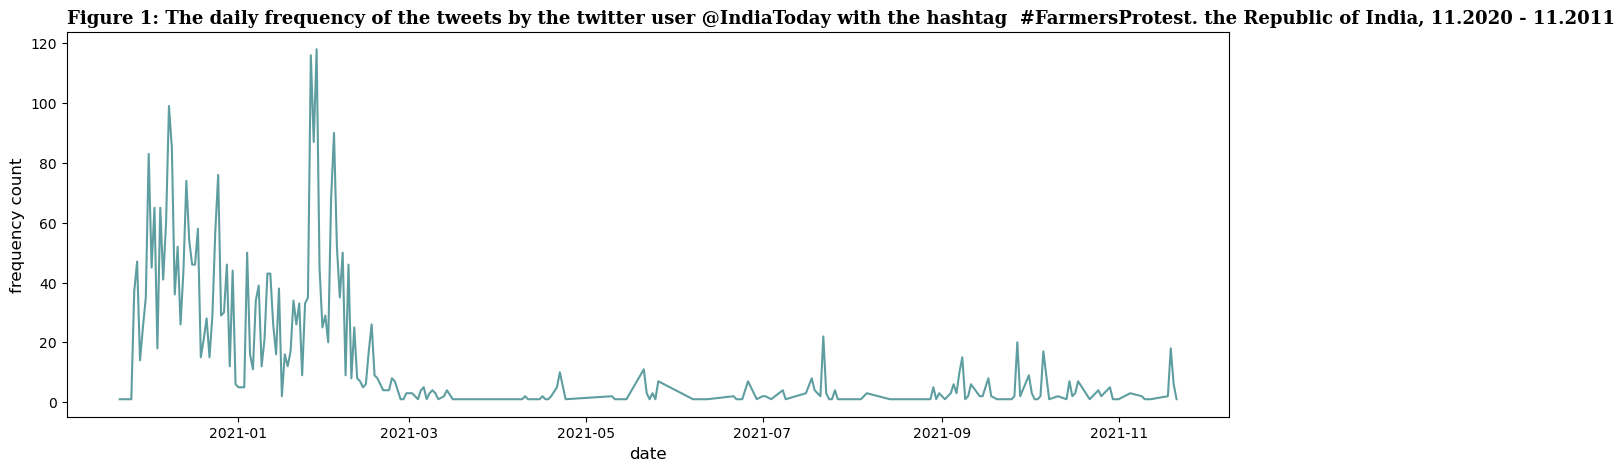

In [62]:
# Creating a variable of tweet frequency.
frequency = df.groupby(['date']).size()

# Plotting a line graph.
fig,ax = plt.subplots(figsize=(15,5))

lineplt = sns.lineplot(data=frequency, color='cadetblue')
lineplt.axes.set_title('Figure 1: The daily frequency of the tweets by the twitter user @IndiaToday with the hashtag  #FarmersProtest. the Republic of India, 11.2020 - 11.2011',
                      font='serif',
                      fontsize=13,
                      fontweight='bold',
                      loc='left')
lineplt.set_xlabel('date', fontsize=12)
lineplt.set_ylabel('frequency count', fontsize=12);

*Interpretation:* It can be seen from the graph that the tweet frequency with the hash tag #FarmersProtest from the user Irish Today was very high at beginning of the event reaching 80-120 tweets per week. And then after february 2021 it became more stable averaging 1-20 per week for the rest of the duration.

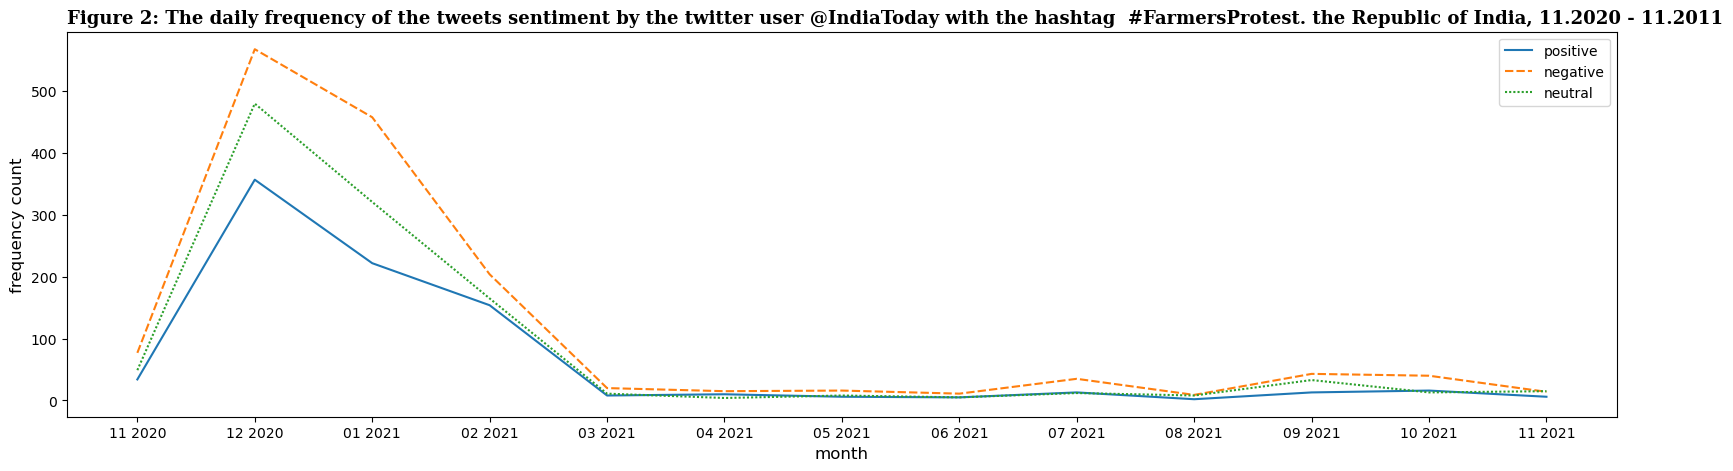

In [63]:
# Adding a new column to DataFrame with month and year input.
df['month'] = df['date'].dt.strftime('%m %Y')

# Separating df by each sentiment.
positive_freq = df[df['sentiment'] == 'positive']
negative_freq = df[df['sentiment'] == 'negative']
neutral_freq = df[df['sentiment'] == 'neutral']

# Creating a Pandas Series with frequancy count for each sentiment.
frequency_p = positive_freq.groupby(['month']).size()
frequency_neg = negative_freq.groupby(['month']).size()
frequency_neu = neutral_freq.groupby(['month']).size()


# Concatinating separe Series.
new_df = pd.concat([frequency_p, frequency_neg, frequency_neu], axis=1)

# Changing index as a column.
new_df = new_df.iloc[[10, 12, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ,11]]

# Renaming the columns.
new_df.rename(columns = {0: 'positive', 1 : 'negative', 2 : 'neutral'}, inplace=True)

# Plotting a line graph.
fig,ax = plt.subplots(figsize=(20,5))

lineplt = sns.lineplot(data=new_df, color='cadetblue')
lineplt.axes.set_title('Figure 2: The daily frequency of the tweets sentiment by the twitter user @IndiaToday with the hashtag  #FarmersProtest. the Republic of India, 11.2020 - 11.2011',
                      font='serif',
                      fontsize=13,
                      fontweight='bold',
                      loc='left')
lineplt.set_xlabel('month', fontsize=12)
lineplt.set_ylabel('frequency count', fontsize=12);

In [64]:
# Printing the total number of 3 different sentiment tweets.
print('Sum of the NEGATIVE sentiment tweets for the whole period is', new_df['negative'].sum())
print('Sum of the NEUTRAL sentiment tweets for the whole period is', new_df['neutral'].sum())
print('Sum of the POSITIVE sentiment tweets for the whole period is', new_df['positive'].sum())

Sum of the NEGATIVE sentiment tweets for the whole period is 1510
Sum of the NEUTRAL sentiment tweets for the whole period is 1124
Sum of the POSITIVE sentiment tweets for the whole period is 846


*Interpretation:* As we can sees from the graph the number of negative tweets were the highest between November 2020 to February 2021 whereas positive tweets number was the lowest and the neutral tweets were in the middle. However starting from March 2021 till the end of spam period number of the tweets in general lowered and there were no much differences between them. Moreover as you can see from the above sell the number of all Negative tweets are 1518, neutral tweets were 1132 and the lowest was the positive tweets with the number of 830 counts.

In [65]:
# Creating DataFrame of most liked tweets.
sorted_df_like = df.sort_values(by='liked', ascending=False)
print('The most liked tweet was:', sorted_df_like.iloc[0,1].upper(), '-tweeted on', sorted_df_like.iloc[0,0], '-liked',  sorted_df_like.iloc[0,5], 'times. \n')
print('The second most liked tweet was:', sorted_df_like.iloc[1,1].upper(), '- tweeted on', sorted_df_like.iloc[1,0], '-liked',  sorted_df_like.iloc[1,5], 'times. \n')
print('The third most liked tweet was:', sorted_df_like.iloc[2,1].upper(), '- tweeted on', sorted_df_like.iloc[2,0], '-liked',  sorted_df_like.iloc[2,5], 'times.')

The most liked tweet was: POP STAR EXTENDS SUPPORT TO PROTESTING FARMERS OPPOSES INTERNET SHUTDOWN IN HARYANA INDIA TODAY' GETS US MORE DETAILS WITH  -tweeted on 2021-02-02 00:00:00 -liked 5413 times. 

The second most liked tweet was: MEET BIR 12 YEAR OLD KID FROM JALANDHAR THIS STUDENT OF CLASS 7TH HAS BEEN ATTENDING HIS ONLINE CLASSES FROM SINGHU BORDER IN DELHI WHERE FARMER' PROTESTS ARE GOING ON WATCH THE VIDEO FIND OUT MORE  - tweeted on 2020-12-11 00:00:00 -liked 1796 times. 

The third most liked tweet was:  WHY ARE ACTORS AND SINGERS PARTICIPATING IN FARMERS' PROTESTS ACTOR DEEP SIDHU EXPLAINS IT FULL VIDEO OF WITH  - tweeted on 2020-12-02 00:00:00 -liked 1693 times.


*Interpretation:* On above sell I executed code to show the 3 most liked tweets from the user @IndiaToday. You can see that the tweet about the singer Rihanna has got the most likes with 5414 times on 2nd of February, 2021.

In [66]:
# Creating DataFrame of most retweeted tweets.
sorted_df_retweet = df.sort_values(by='retweeted', ascending=False)
print('The most liked tweet was:', sorted_df_retweet.iloc[0,1].upper(), '-tweeted on', sorted_df_retweet.iloc[0,0], '-retweeted',  sorted_df_retweet.iloc[0,4], 'times. \n')
print('The second most liked tweet was:', sorted_df_retweet.iloc[1,1].upper(), '- tweeted on', sorted_df_retweet.iloc[1,0], '-retweeted',  sorted_df_retweet.iloc[1,4], 'times. \n')
print('The third most liked tweet was:', sorted_df_retweet.iloc[2,1].upper(), '- tweeted on', sorted_df_retweet.iloc[2,0], '-retweeted',  sorted_df_retweet.iloc[2,4], 'times.')

The most liked tweet was: POP STAR EXTENDS SUPPORT TO PROTESTING FARMERS OPPOSES INTERNET SHUTDOWN IN HARYANA INDIA TODAY' GETS US MORE DETAILS WITH  -tweeted on 2021-02-02 00:00:00 -retweeted 1332 times. 

The second most liked tweet was: COMMUNICATION SPECIALIST ASMITA GHOSH EXPLAINS WHAT EXACTLY SOCIAL MEDIA 'TOOLKIT' IS ALL ABOUT WATCH WITH LIVE  - tweeted on 2021-02-04 00:00:00 -retweeted 432 times. 

The third most liked tweet was: IS THE OPPOSITION GUILTY OF DUPLICITY ON FARM LAWS HERE' AN ANALYSIS  - tweeted on 2020-12-16 00:00:00 -retweeted 386 times.


*Interpretation:* On above sell I executed code to show the 3 most retweeted tweets from the user @IndiaToday. You can see that the tweet about the singer Rihanna again has got the most retweets with 1332 times times on 2nd of February, 2021.

In [67]:
# Tokenizing the column 'token'.
df['token'] = df['token'].apply(word_tokenize)
all_token_words = [word for tokens in df['token'] for word in tokens]

# Counting word frequencies
word_freq = pd.Series(all_token_words).value_counts()

# Printing top 5 frequent words in all tweets from @IndiaToday.
print('The most frequent word that is used on tweet from the user @India Today was the word:', word_freq.index[0].upper(), '- with the count of:', word_freq[0])
print('The second, third, fourth, fifth the most frequent word that is used on tweet from the user @India Today was the word:', word_freq.index[1].upper(), \
                                                                                                                                 word_freq.index[2].upper(), \
                                                                                                                                  word_freq.index[3].upper(), \
                                                                                                                                  word_freq.index[4].upper(),'- with the count of:',\
      word_freq[1], \
       word_freq[2], \
      word_freq[3], \
        word_freq[4], 'respectively.')

The most frequent word that is used on tweet from the user @India Today was the word: FARMER - with the count of: 2159
The second, third, fourth, fifth the most frequent word that is used on tweet from the user @India Today was the word: PROTEST WATCH DELHI LAW - with the count of: 637 560 476 404 respectively.


*Interpretation:* On above sell I executed code to show the 5 most tokenized tweeted words from the user @IndiaToday. As you can see the Farmer is the most frequent word with the count of 2159 times in total.

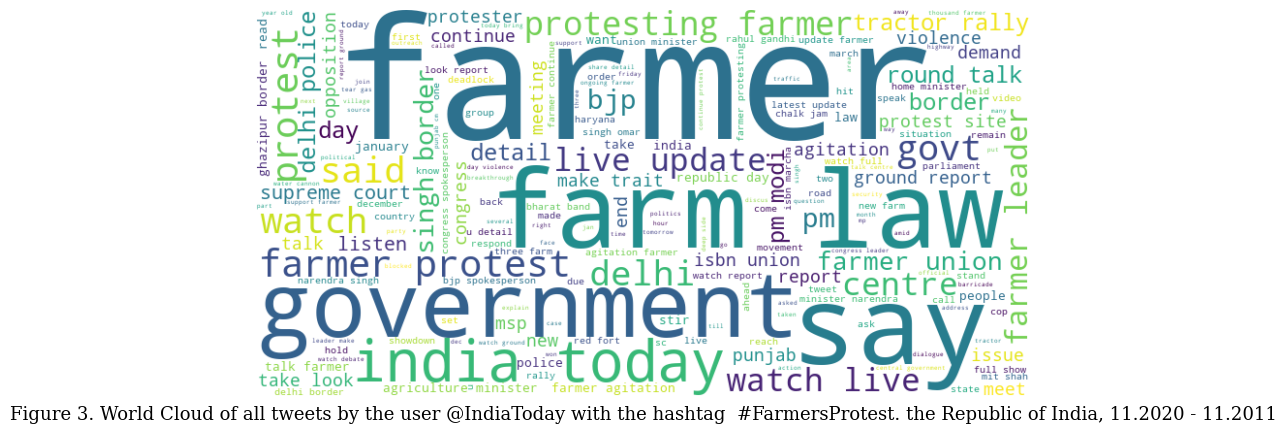

In [68]:
# WordCloud plot for all words.
text = ' '.join(all_token_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 3. World Cloud of all tweets by the user @IndiaToday with the hashtag  #FarmersProtest. the Republic of India, 11.2020 - 11.2011',\
         fontproperties='serif',
         fontsize=13,
         y=-0.08)
plt.show()

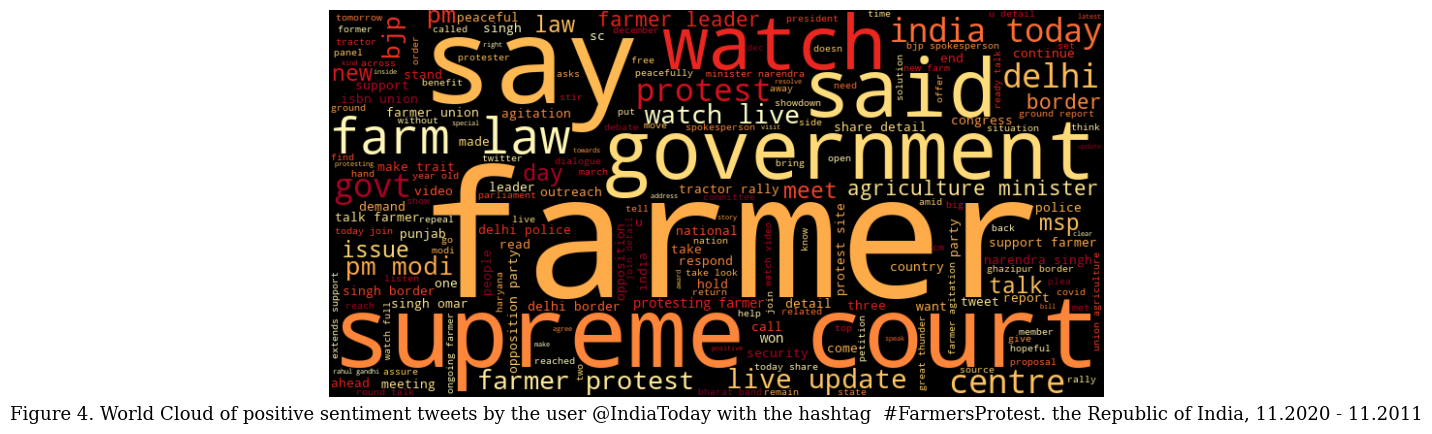

In [69]:
# WordCloud plot for positive sentiment tokens.
positive_freq['token'] = positive_freq['token'].apply(word_tokenize)
all_pos_tokens = [word for tokens in positive_freq['token'] for word in tokens]
text = ' '.join(all_pos_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='YlOrRd').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 4. World Cloud of positive sentiment tweets by the user @IndiaToday with the hashtag  #FarmersProtest. the Republic of India, 11.2020 - 11.2011',\
         fontproperties='serif',
         fontsize=13,
         y=-0.08)
plt.show()

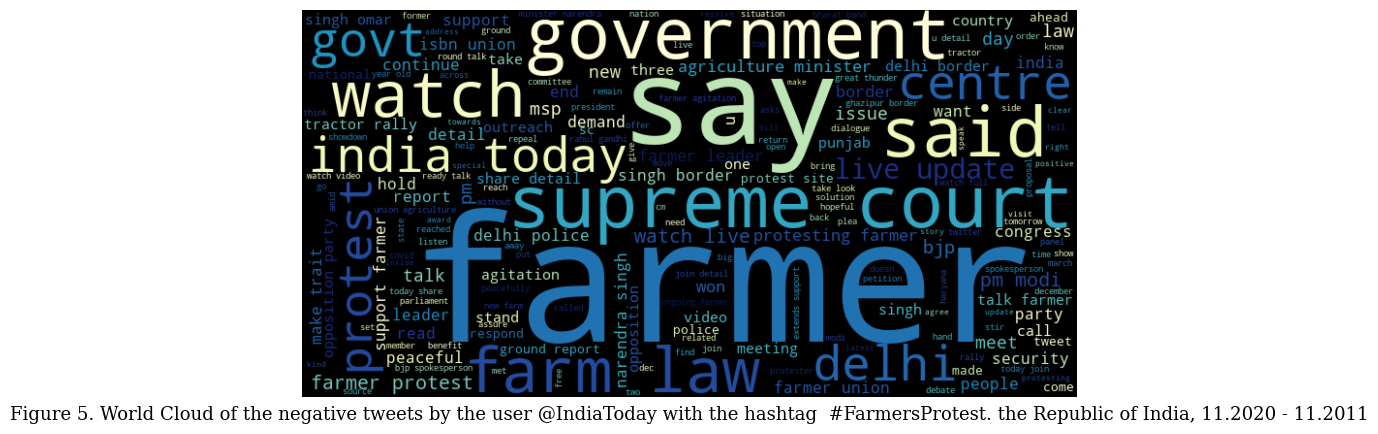

In [70]:
# WordCloud plot for negative sentiment tokens.
negative_freq['token'] = negative_freq['token'].apply(word_tokenize)
all_neg_tokens = [word for tokens in negative_freq['token'] for word in tokens]
text = ' '.join(all_pos_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='YlGnBu').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title('Figure 5. World Cloud of the negative tweets by the user @IndiaToday with the hashtag  #FarmersProtest. the Republic of India, 11.2020 - 11.2011',\
         fontproperties='serif',
         fontsize=13,
         y=-0.08)
plt.show;

*Interpretation:* As I can see from above three WordCloud plots it is obvious that the IndiaToday twitter page is not declining to one side. Thier tweets regarding to the protest not provoking niether side.

### *3.2 Forecasting using ARIMA model*

For forecasting the value of the "polarity" column of the data I decided to use ARIMA model. Because it has relatively simple and and small number of parameters to estimate. 

#### *laoding and examining dataset*

In [75]:
# Creaating a new DataFrame for timerseries model.
df_timeseries = df[['date', 'polarity']].copy()

# Making the 'date' column as an index.
df_timeseries.set_index('date', inplace=True)

In [76]:
# Chancking the changes.
df_timeseries.head(2)

,polarity
date,
2020-11-21,-0.128
2020-11-25,0.000


<Axes: xlabel='date'>

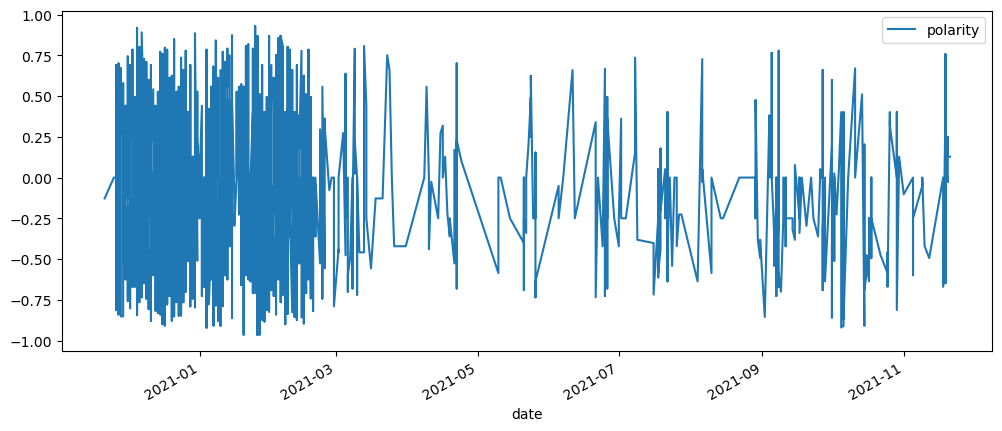

In [77]:
# Checking the data.
df_timeseries.plot(figsize=(12,5))

In [78]:
# Stationary check.
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1.ADF: ', dftest[0])
    print('2.P-Value: ', dftest[1])
    print('3.Num of lags: ', dftest[2])
    print('4.Num of observations used for ADF regression and cricital values calculation :', dftest[3])
    print('5.Critical Values: ')
    for key, val in dftest[4].items():
        print('\t', key, ': ', val)

In [79]:
# Testing stationary check.
ad_test(df_timeseries['polarity'])

1.ADF:  -6.486637981046936
2.P-Value:  1.2561377426869834e-08
3.Num of lags:  26
4.Num of observations used for ADF regression and cricital values calculation : 3453
5.Critical Values: 
	 1% :  -3.432245212262408
	 5% :  -2.8623773963331276
	 10% :  -2.5672157612208255


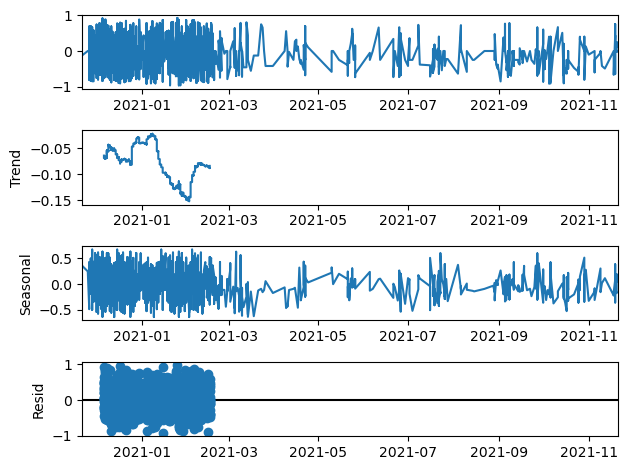

In [80]:
# Plotting stationarity.
decomposition = sm.tsa.seasonal_decompose(df_timeseries, model='additive', period=30*30)
decomposition.plot()
plt.show()

Since the P-value of the test is very small number, I can see that the dataset is pretty stationarry and it also can be seen from above graph. There is no trend and residual.

In [81]:
# Figuring out order for ARIMA model.
stepwise_fit = auto_arima(df_timeseries['polarity'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2927.253, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5132.475, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4158.952, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2924.703, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5130.475, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2924.236, Time=1.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2925.191, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2926.350, Time=1.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2924.323, Time=1.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3778.213, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2922.237, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2922.705, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4156.952, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2923.191, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3480
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1458.118
Date:                Fri, 26 May 2023   AIC                           2922.237
Time:                        21:42:46   BIC                           2940.700
Sample:                             0   HQIC                          2928.828
                               - 3480                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0277      0.016      1.683      0.092      -0.005       0.060
ma.L1         -0.9706      0.004   -232.246      0.000      -0.979      -0.962
sigma2         0.1353      0.004     38.236      0.000       0.128       0.142
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.81
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the test done above I can see that the best model for ARIMA (p, d, q) is (1, 1, 1). And since there is no seosonality it is basically an ARIMA model.

#### *train test split*

In [82]:
# Train test split.
print(df_timeseries.shape)
train_data = df_timeseries.iloc[:-30]
test_data = df_timeseries.iloc[-30:]
print(train_data.shape, test_data.shape)

(3480, 1)
(3450, 1) (30, 1)


Since the data in the column polarity is ranging between -1 to 1 I don't need to use normalization or transformation tools.

#### *training and fitting the model*

For the training model we are using (1,1,1) order.

In [83]:
# Training the model
model = ARIMA(train_data['polarity'], order=(1,1,1))
model = model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               polarity   No. Observations:                 3450
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1449.653
Date:                Fri, 26 May 2023   AIC                           2905.307
Time:                        21:42:58   BIC                           2923.745
Sample:                             0   HQIC                          2911.892
                               - 3450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0263      0.017      1.589      0.112      -0.006       0.059
ma.L1         -0.9710      0.004   -235.004      0.000      -0.979      -0.963
sigma2         0.1356      0.004     37.962      0.0

#### *forecasting*

In [85]:
# Making predictions on the set.
start_index = len(train_data)
end_index = len(train_data) + len(test_data) - 1
pred = model.predict(start=start_index, end=end_index, typ ='levels')

pred.index = df_timeseries.index[start_index:end_index+1]
print(pred)

date
2021-11-09   -0.199518
2021-11-10   -0.203404
2021-11-12   -0.203506
2021-11-18   -0.203509
2021-11-18   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-19   -0.203509
2021-11-20   -0.203509
2021-11-20   -0.203509
2021-11-20   -0.203509
2021-11-20   -0.203509
2021-11-20   -0.203509
2021-11-20   -0.203509
2021-11-21   -0.203509
Name: predicted_mean, dtype: float64


<Axes: xlabel='date'>

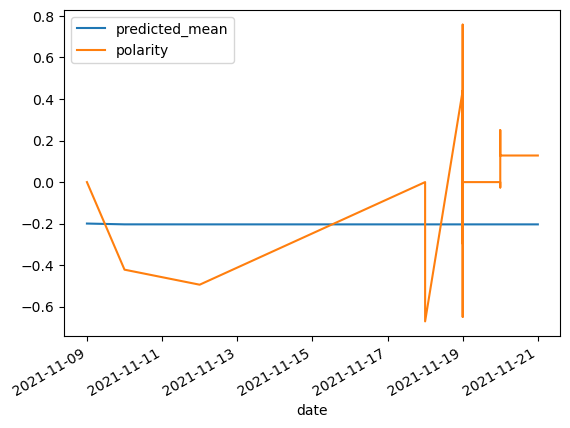

In [86]:
# Plotting prediction
pred.plot(legend=True)
test_data['polarity'].plot(legend=True)

#### *interpretation*

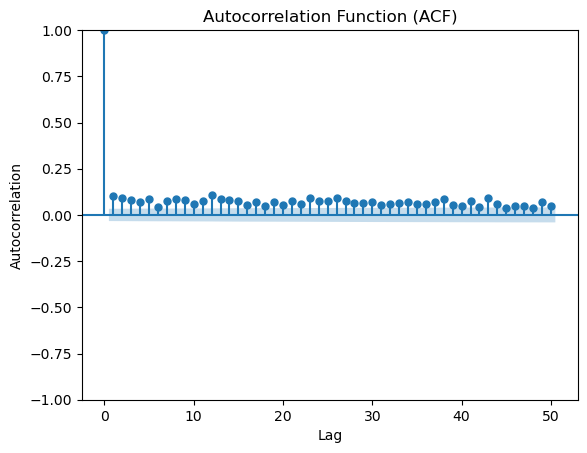

In [87]:
# Plotting the autocorrelation with 50 lags.
plot_acf(df_timeseries['polarity'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

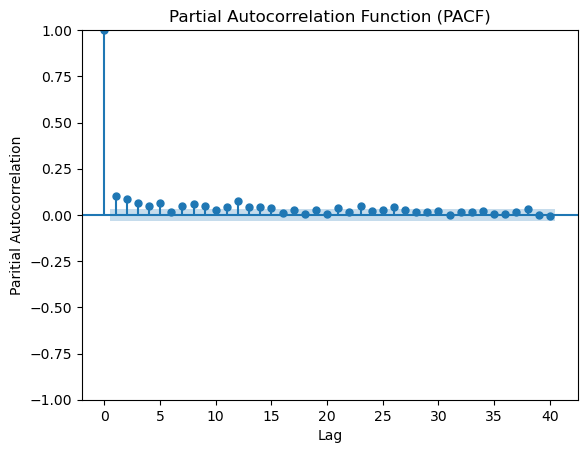

In [88]:
# Paritial Autocorrelation with 50 lags.
plot_pacf(df_timeseries['polarity'], lags=40)
plt.xlabel('Lag')
plt.ylabel('Paritial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

*Interpretation:* Prediction and the plot above shows that there is no trend information that Arima can learn. That's why it generating some random value closer to training data values, and each prediction will be more and less same because of the data, which is not following any trend. There will be no prediction it can be also seen from prediction data, the prediction are converges to one value, so if all the previous values are same then it will generate same next value.

## 4. Sentimental analysis model in Pyspark.

For the sentimental analysis I choose to use Logistic regresion on Pyspark. The data for this model is already had done proccessing so in this section I'll do just a few changes with the dataset.

#### *loading and examining of the dataset*

In [89]:
# Checking the DataFrame.
df_spark_sentiment.show(3)

+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+---------+
|                date|               tweet|          last_token|replied|retweeted|liked|quoted|sentiment_polarity|sentiment|
+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+---------+
|2020-11-21 11:04:...|farmers allow tra...|farmer allow trai...|      0|        1|   17|     0|            -0.128| negative|
|2020-11-25 09:38:...|police resorted t...|police resorted u...|      0|        2|   13|     0|               0.0|  neutral|
|2020-11-26 04:14:...|heavy police depl...|heavy police depl...|      0|        2|    8|     0|               0.0|  neutral|
+--------------------+--------------------+--------------------+-------+---------+-----+------+------------------+---------+
only showing top 3 rows



In [90]:
# Dropping coplumns.
df_spark_sentiment = df_spark_sentiment.drop('date', 'tweet', 'replied', 'retweeted', 'liked', 'quoted', 'sentiment_polarity')

# Selecting data. 
df_spark_sentiment = df_spark_sentiment.withColumn('sentiment', when(col('sentiment') == 'positive', 1)
                                                   .when(col('sentiment') == 'neutral', 0)
                                                   .when(col('sentiment') == 'negative', 0)
                                                   .otherwise(col('sentiment')))
# Renaming the columns.
df_spark_sentiment = df_spark_sentiment.select(col('last_token').alias('tweet'),
                                       col('sentiment').alias('label'))

In [91]:
# Splitting tweet column into tokenized text.
tokenizer = Tokenizer(inputCol='tweet', outputCol='token')
df_spark_sentiment = tokenizer.transform(df_spark_sentiment)

# Apply Hashing TF to the token column.
hasing_tf = HashingTF(inputCol='token', outputCol='features')
df_spark_sentiment = hasing_tf.transform(df_spark_sentiment)

# Dropping columns.
df_spark_sentiment = df_spark_sentiment.drop('tweet', 'token')

# Column reorder.
df_spark_sentiment = df_spark_sentiment.select('features', 'label')

# Changing to integer.
df_spark_sentiment = df_spark_sentiment.withColumn('label',col('label').cast('integer'))

In [92]:
# Checking the changes.
df_spark_sentiment.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(262144,[13003,18...|    0|
|(262144,[13003,67...|    0|
|(262144,[1797,130...|    0|
|(262144,[13003,67...|    0|
|(262144,[13003,21...|    0|
+--------------------+-----+
only showing top 5 rows



#### *training and fitting the model*

In [93]:
# Dividing data into training and testing. 70%-train 30%-test

divided_data = df_spark_sentiment.randomSplit([0.7, 0.3])
train_data = divided_data[0]
test_data = divided_data[1]
print("train:", train_data.count(), '\n test:', test_data.count())

train: 2433 
 test: 1047


In [94]:
# Fitting the model
lr = LogisticRegression(labelCol='label', featuresCol='features')
model = lr.fit(train_data)

2023-05-26 21:46:12,725 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2023-05-26 21:46:12,730 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


#### *tesing the data*

In [96]:
# Testing the data
prediction = model.transform(test_data)
prediction.show(10)
result = prediction.filter(
    prediction['label'] == prediction['prediction']).count()
total_data = prediction.count()
print('correct prediction:', result, ',total data:', total_data, ', accuracy:', result/total_data)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(262144,[161,6034...|    0|[47.5538429128749...|           [1.0,0.0]|       0.0|
|(262144,[161,1080...|    0|[34.1183561565096...|[0.99999999999999...|       0.0|
|(262144,[161,1300...|    0|[-5.5156006653789...|[0.00400738607216...|       1.0|
|(262144,[161,1300...|    0|[23.9092429285258...|[0.99999999995866...|       0.0|
|(262144,[161,2243...|    1|[-39.635422382054...|[6.11722946262370...|       1.0|
|(262144,[161,3412...|    0|[33.2313553542522...|[0.99999999999999...|       0.0|
|(262144,[161,6082...|    0|[21.9529266232131...|[0.99999999970760...|       0.0|
|(262144,[531,619,...|    0|[-4.7622812446891...|[0.00847367461971...|       1.0|
|(262144,[531,1002...|    1|[-63.025331133649...|[4.25056310810467...|       1.0|
|(262144,[531,13

correct prediction: 882 ,total data: 1047 , accuracy: 0.8424068767908309


#### *interpretation*

*Interpretation* Is you can see for sentimental analysis I used Logstics Regrassion. I trained 2406 rows of data and tested 1074 rows of data. And after training and fitting the model I tested with the accurace of 0.84. Logistic regression works well for my dataset.